## Decision Tree

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
import os

DATA_DIR = './data'
DATA_FILE = 'churn_data_encoded.csv'

data_path = os.path.join(DATA_DIR, DATA_FILE)
data = pd.read_csv(data_path, sep=',')
print(data.head())

   Churn  Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
0      0       0   36         0               0        1           0   
1      0       1   46         0               0        0           0   
2      1       1   37         0               0        0           0   
3      0       1   53         0               0        0           0   
4      1       0   19         1               0        0           1   

   Number of Dependents  Zip Code   Latitude  ...  Offer_Offer E  \
0                     0     90001  33.973616  ...           True   
1                     0     90002  33.949255  ...          False   
2                     0     90003  33.964131  ...          False   
3                     0     90004  34.076259  ...          False   
4                     2     90005  34.059281  ...          False   

   Internet Type_Cable  Internet Type_DSL  Internet Type_Fiber Optic  \
0                False               True                      False   
1             

In [3]:
data[data['Churn'] == 1]

,Churn,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Zip Code,Latitude,...,Offer_Offer E,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
2,1,1,37,0,0,0,0,0,90003,33.964131,...,False,False,True,False,True,False,False,False,True,False
4,1,0,19,1,0,0,1,2,90005,34.059281,...,False,False,False,True,True,False,False,True,False,False
5,1,0,31,0,0,0,1,2,90006,34.048013,...,False,True,False,False,True,False,False,True,False,False
8,1,0,23,1,0,1,1,3,90010,34.062125,...,False,False,False,True,True,False,False,True,False,False
13,1,1,38,0,0,0,1,1,90015,34.039224,...,False,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1,1,44,0,0,0,0,0,92264,33.745746,...,False,True,False,False,False,True,False,True,False,False
7026,1,0,40,0,0,0,0,0,92273,32.790282,...,False,True,False,False,True,False,False,True,False,False
7032,1,1,79,0,1,0,0,0,92027,33.141265,...,False,False,False,True,True,False,False,True,False,False
7034,1,0,28,1,0,0,0,0,92282,33.972293,...,False,False,False,True,True,False,False,False,True,False


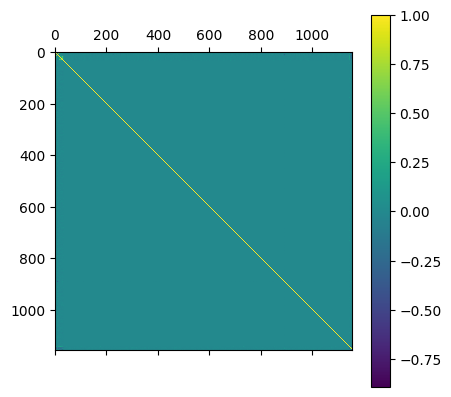

In [5]:
import matplotlib.pyplot as plt

correlation_matrix = data.corr()

plt.matshow(correlation_matrix)
plt.colorbar()

plt.show()

### Highest Correlation

In [6]:
upper_corr_mat = correlation_matrix.where( 
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))   
  
unique_corr_pairs = upper_corr_mat.unstack().dropna() 

sorted_mat = unique_corr_pairs.sort_values() 
print(sorted_mat)

Payment Method_Credit Card  Payment Method_Bank Withdrawal   -0.893593
Longitude                   Latitude                         -0.885979
                            Zip Code                         -0.790564
Satisfaction Score          Churn                            -0.754649
Under 30                    Age                              -0.672651
                                                                ...   
Total Revenue               Tenure in Months                  0.853146
Number of Dependents        Dependents                        0.888234
Latitude                    Zip Code                          0.894769
Referred a Friend           Married                           0.949987
Total Revenue               Total Charges                     0.972212
Length: 667590, dtype: float64


## Classification

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Features und Zielvariable trennen
X = data.drop(columns=['Churn'])
y = data['Churn']

# Überprüfen der Klassenverteilung
print(y.value_counts())

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check if classes are balanced
print(y_resampled.value_counts())

# Scale features from 0 to 1
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Define own scoring function based on estimated FP and FN costs
def custom_score(y_true, y_pred):
    # Define scores: FP = 1, FN = 5, TP = TN = 0
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total # set score in relation to total number of samples
    return score

def print_scores(scores):
    # Print scores for each fold
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
        })
    print("Scores:\n", scores_df)

    # Print average scores
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)

def evaluate_classification(X, y, classifier):
    # Create custom scorer
    custom_scorer = make_scorer(custom_score, greater_is_better=False)

    # Use cross-validation to evaluate performance
    cv = StratifiedKFold(
        shuffle=True,
        n_splits=5,
        random_state=42
        )

    scores = cross_validate(
        classifier, 
        X, 
        y, 
        cv=cv, scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'custom_score': custom_scorer,
        })
    
    print_scores(scores)
    return scores

# Initialize classifier with increased max_iter
clf = MLPClassifier(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    random_state=42,
    max_iter=1000,  # Increase max_iter to 1000
)

# Evaluate classification
scores = evaluate_classification(X_resampled_scaled, y_resampled, clf)

# Define and execute grid search
def apply_grid_search(classifier, param_grid, X, y, cv=10, scoring='accuracy'):
    # Use grid search to find best hyperparameters
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)

    # Print best hyperparameters
    print("Best hyperparameters:")
    print(grid_search.best_params_)

param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3],
    'hidden_layer_sizes': [(5, 2), (10, 5), (20, 10)],
    'solver': ['adam', 'sgd'],
}

apply_grid_search(MLPClassifier(max_iter=1000), param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')


Churn
0    5174
1    1869
Name: count, dtype: int64
Churn
0    5174
1    5174
Name: count, dtype: int64
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.964251   0.953730  0.975845  0.964661     -0.084058
1     2  0.967150   0.962679  0.971981  0.967308     -0.088889
2     3  0.970048   0.964661  0.975845  0.970221     -0.078261
3     4  0.964234   0.958891  0.970019  0.964423     -0.095698
4     5  0.958434   0.953200  0.964251  0.958694     -0.113098

Statistics:
                    Min      Mean       Max
accuracy      0.958434  0.964823  0.970048
precision       0.9532  0.958632  0.964661
recall        0.964251  0.971588  0.975845
f1            0.958694  0.965061  0.970221
custom_score -0.113098 -0.092001 -0.078261
Best hyperparameters:
{'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}


## Optimisation (Bagging and Boosting)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Evaluierung des Klassifikationsmodells
def evaluate_classification_optimising(model, X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Metriken
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }
    
    # Kreuzvalidierung 
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Precision: {scores['test_precision'].mean():.4f}")
    print(f"Recall: {scores['test_recall'].mean():.4f}")
    print(f"F1-Score: {scores['test_f1'].mean():.4f}")
    
    return scores

# Parametergitter für RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search für RandomForestClassifier
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X, y)

# Beste Parameter für RandomForestClassifier
print("Best parameters for RandomForestClassifier:", rf_grid_search.best_params_)

# Evaluieren des besten RandomForestClassifiers
rf_best_model = rf_grid_search.best_estimator_
rf_scores = evaluate_classification_optimising(rf_best_model, X, y)
print("RandomForestClassifier Results:")
print_scores(rf_scores)

# Parametergitter für AdaBoostClassifier
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Grid Search für AdaBoostClassifier
ab_grid_search = GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'), param_grid=ab_param_grid, cv=5)
ab_grid_search.fit(X, y)

# Beste Parameter für AdaBoostClassifier
print("Best parameters for AdaBoostClassifier:", ab_grid_search.best_params_)

# Evaluieren des besten AdaBoostClassifiers
ab_best_model = ab_grid_search.best_estimator_
ab_scores = evaluate_classification_optimising(ab_best_model, X, y)
print("AdaBoostClassifier Results:")
print_scores(ab_scores)

Best parameters for RandomForestClassifier: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9512
Precision: 0.9636
Recall: 0.8480
F1-Score: 0.9020
RandomForestClassifier Results:
Scores:
    Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.957447   0.964497  0.871658  0.915730
1     2  0.954610   0.969697  0.855615  0.909091
2     3  0.961702   0.970588  0.882353  0.924370
3     4  0.948864   0.968750  0.833333  0.895954
4     5  0.948864   0.968944  0.834225  0.896552
5     6  0.955966   0.964286  0.866310  0.912676
6     7  0.921875   0.902439  0.791444  0.843305
7     8  0.950284   0.981013  0.828877  0.898551
8     9  0.950284   0.963415  0.844920  0.900285
9    10  0.961648   0.981928  0.871658  0.923513

Statistics:
                      Min    Median       Max
test_accuracy   0.921875  0.952447  0.961702
test_precision  0.902439  0.968847  0.981928
test_recall     0.791444  0.850267  0.882353
test_f1         0.843305  0.904688   0.92437
Best pa

In [6]:
# grid search
def apply_grid_search(classifier, param_grid, X, y, cv=10, scoring='accuracy'):
    # Use grid search to find best hyperparameters
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)

    # Print best hyperparameters
    print("Best hyperparameters:")
    print(grid_search.best_params_)
    
    return grid_search.best_estimator_

# param grid für RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search for RandomForestClassifier
rf_best_model = apply_grid_search(RandomForestClassifier(), rf_param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

# Evaluate best RandomForestClassifiers
rf_scores = evaluate_classification(X_resampled_scaled, y_resampled, rf_best_model)
print("RandomForestClassifier Results:")
print_scores(rf_scores)

# param grid for AdaBoostClassifier
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Grid Search for AdaBoostClassifier
ab_best_model = apply_grid_search(AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'), ab_param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

# Evaluate the best AdaBoostClassifiers
ab_scores = evaluate_classification(X_resampled_scaled, y_resampled, ab_best_model)
print("AdaBoostClassifier Results:")
print_scores(ab_scores)

Best hyperparameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.973913   0.980411  0.967150  0.973735     -0.091787
1     2  0.971498   0.977495  0.965217  0.971317     -0.098068
2     3  0.973913   0.982301  0.965217  0.973684     -0.095652
3     4  0.960851   0.973188  0.947776  0.960314     -0.143548
4     5  0.971967   0.984143  0.959420  0.971624     -0.109232

Statistics:
                    Min      Mean       Max
accuracy      0.960851  0.970428  0.973913
precision     0.973188  0.979508  0.984143
recall        0.947776  0.960956   0.96715
f1            0.960314  0.970135  0.973735
custom_score -0.143548 -0.107657 -0.091787
RandomForestClassifier Results:
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.973913   0.980411  0.967150  0.973735     -0.091787
1     2  0.971498   0.977495  0.965217  0.971317     -0.098068
2     3  0.973913   0.98